NIM: 6701210054
Nama: Rayhan Aliffio Wibowo
Kelas: D3SI-45-02

# Customer Clustering Analysis (Original Desc)



---

## Goal:
The goal of this project is to conduct an analysis on how customers' shopping behavior are related to their background such as their age, income, and number of children etc.

## Outline:
Some interesting story insights are introduced as we explore the data through EDA analysis. Followed by 3 clustering models: KMeans, DBSCAN, and Gaussian Mixture Model (GMM), along with some parameter tuning exercises. Finally, we will compare the performance of the models, and discuss some future potential analysis to enhance this research.

---

# Customer Clustering Analysis (Current)


---

## Tujuan:
Tujuan dari proyek ini adalah untuk melakukan analisis tentang bagaimana perilaku belanja pelanggan terkait dengan latar belakang mereka seperti usia, pendapatan, jumlah anak, dll.

## Outline:
Beberapa wawasan cerita yang menarik diperkenalkan saat kita mengeksplorasi data melalui analisis EDA. Dilanjutkan dengan 3 model pengelompokan: KMeans, DBSCAN, dan Gaussian Mixture Model (GMM), bersama dengan beberapa latihan penyetelan parameter. Terakhir, kami akan membandingkan kinerja model-model tersebut, dan mendiskusikan beberapa analisis potensial di masa depan untuk menyempurnakan penelitian ini.

---

# Some main columns used in this project:
- Age
- Education
- Income
- Number of Children in customer's household
- Complain: whether the customer complained in the last 2 years
- Cost: Total amount spent on gold in last 2 years
- Deals: Number of purchases made with a discount

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import + Load Dataset

In [2]:
import os
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

customers = pd.read_csv('/content/drive/MyDrive/2023 - IDL/Dataset (TA)/marketing_campaign.csv',delimiter='\t')
customers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Data EDA (Exploratory Data Analysis)
- Data prep (Cleaning, Relevant Columns, Remove Outliers)
- Imputation (Fill Mising Value)
- Remove outliers
- Insights from viz

In [3]:
# Data Prep (Cleaning + Relevant Columns)

customers['Age'] = 2021 - customers['Year_Birth'] # 2021 was the year of the data captured
customers['Children'] = customers['Kidhome'] + customers['Teenhome'] # Menggabungkan Anak dan Remaja kedalam "Children"

cost_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'] # Menghitung jumlah pembelian pelanggan menjadi satu
customers['Cost'] = customers[cost_columns].sum(axis=1)

data = customers.rename(columns={'NumDealsPurchases':'Deals'}) # Mengganti nama "NumDealsPurchases" menjadi "Deals"

data = data[['Age', 'Education', 'Income', 'Children', 'Complain', 'Cost', 'Deals']] # Relevant Columns
data

,Age,Education,Income,Children,Complain,Cost,Deals
0,64,Graduation,58138.0,0,0,1617,3
1,67,Graduation,46344.0,2,0,27,2
2,56,Graduation,71613.0,0,0,776,1
3,37,Graduation,26646.0,1,0,53,2
4,40,PhD,58293.0,1,0,422,5
...,...,...,...,...,...,...,...
2235,54,Graduation,61223.0,1,0,1341,2
2236,75,PhD,64014.0,3,0,444,7
2237,40,Graduation,56981.0,0,0,1241,1
2238,65,Master,69245.0,1,0,843,2


## Check missing values
*Income* column has some values missing, which makes sense as it could be privacy for some people, so here we are replacing those with modes, instead of means because the outliers to the right may skew the mean higher.

Couple other observations:
- Most customers income are gathered between \$30k to \$90k.
- There are small number of customers who made over $600k, which is lovely.. but we are excluding those for this analysis for better clustering result.


In [4]:
data.isnull().any()

Age          False
Education    False
Income        True
Children     False
Complain     False
Cost         False
Deals        False
dtype: bool

In [5]:
data.describe()

,Age,Income,Children,Complain,Cost,Deals
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52.194196,52247.251354,0.950446,0.009375,605.798214,2.325000
std,11.984069,25173.076661,0.751803,0.096391,602.249288,1.932238
min,25.000000,1730.000000,0.000000,0.000000,5.000000,0.000000
25%,44.000000,35303.000000,0.000000,0.000000,68.750000,1.000000
50%,51.000000,51381.500000,1.000000,0.000000,396.000000,2.000000
75%,62.000000,68522.000000,1.000000,0.000000,1045.500000,3.000000
max,128.000000,666666.000000,3.000000,1.000000,2525.000000,15.000000


<Axes: xlabel='Income', ylabel='Count'>

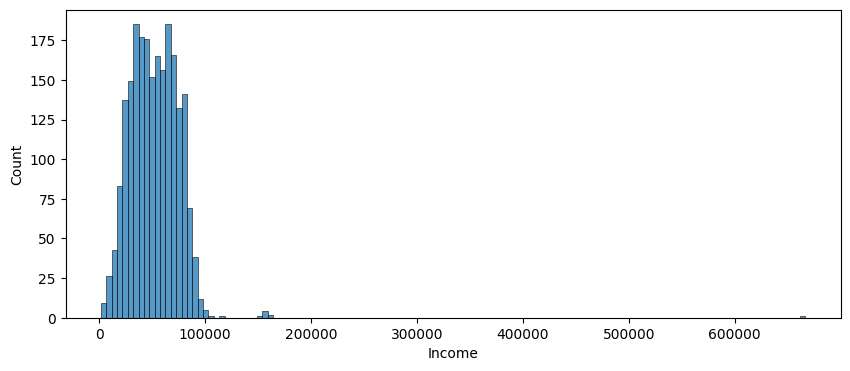

In [10]:
fig, axs = plt.subplots(figsize=(10, 4))
sns.histplot(data, x='Income')

## Imputation (Mode)

In [7]:
data['Income'].fillna((data['Income'].mode()), inplace=True)

# Mode(Modus) digunakan karena adanya outlier yang dapat mempengaruhi handling missing data...

## Peek Column Relationships

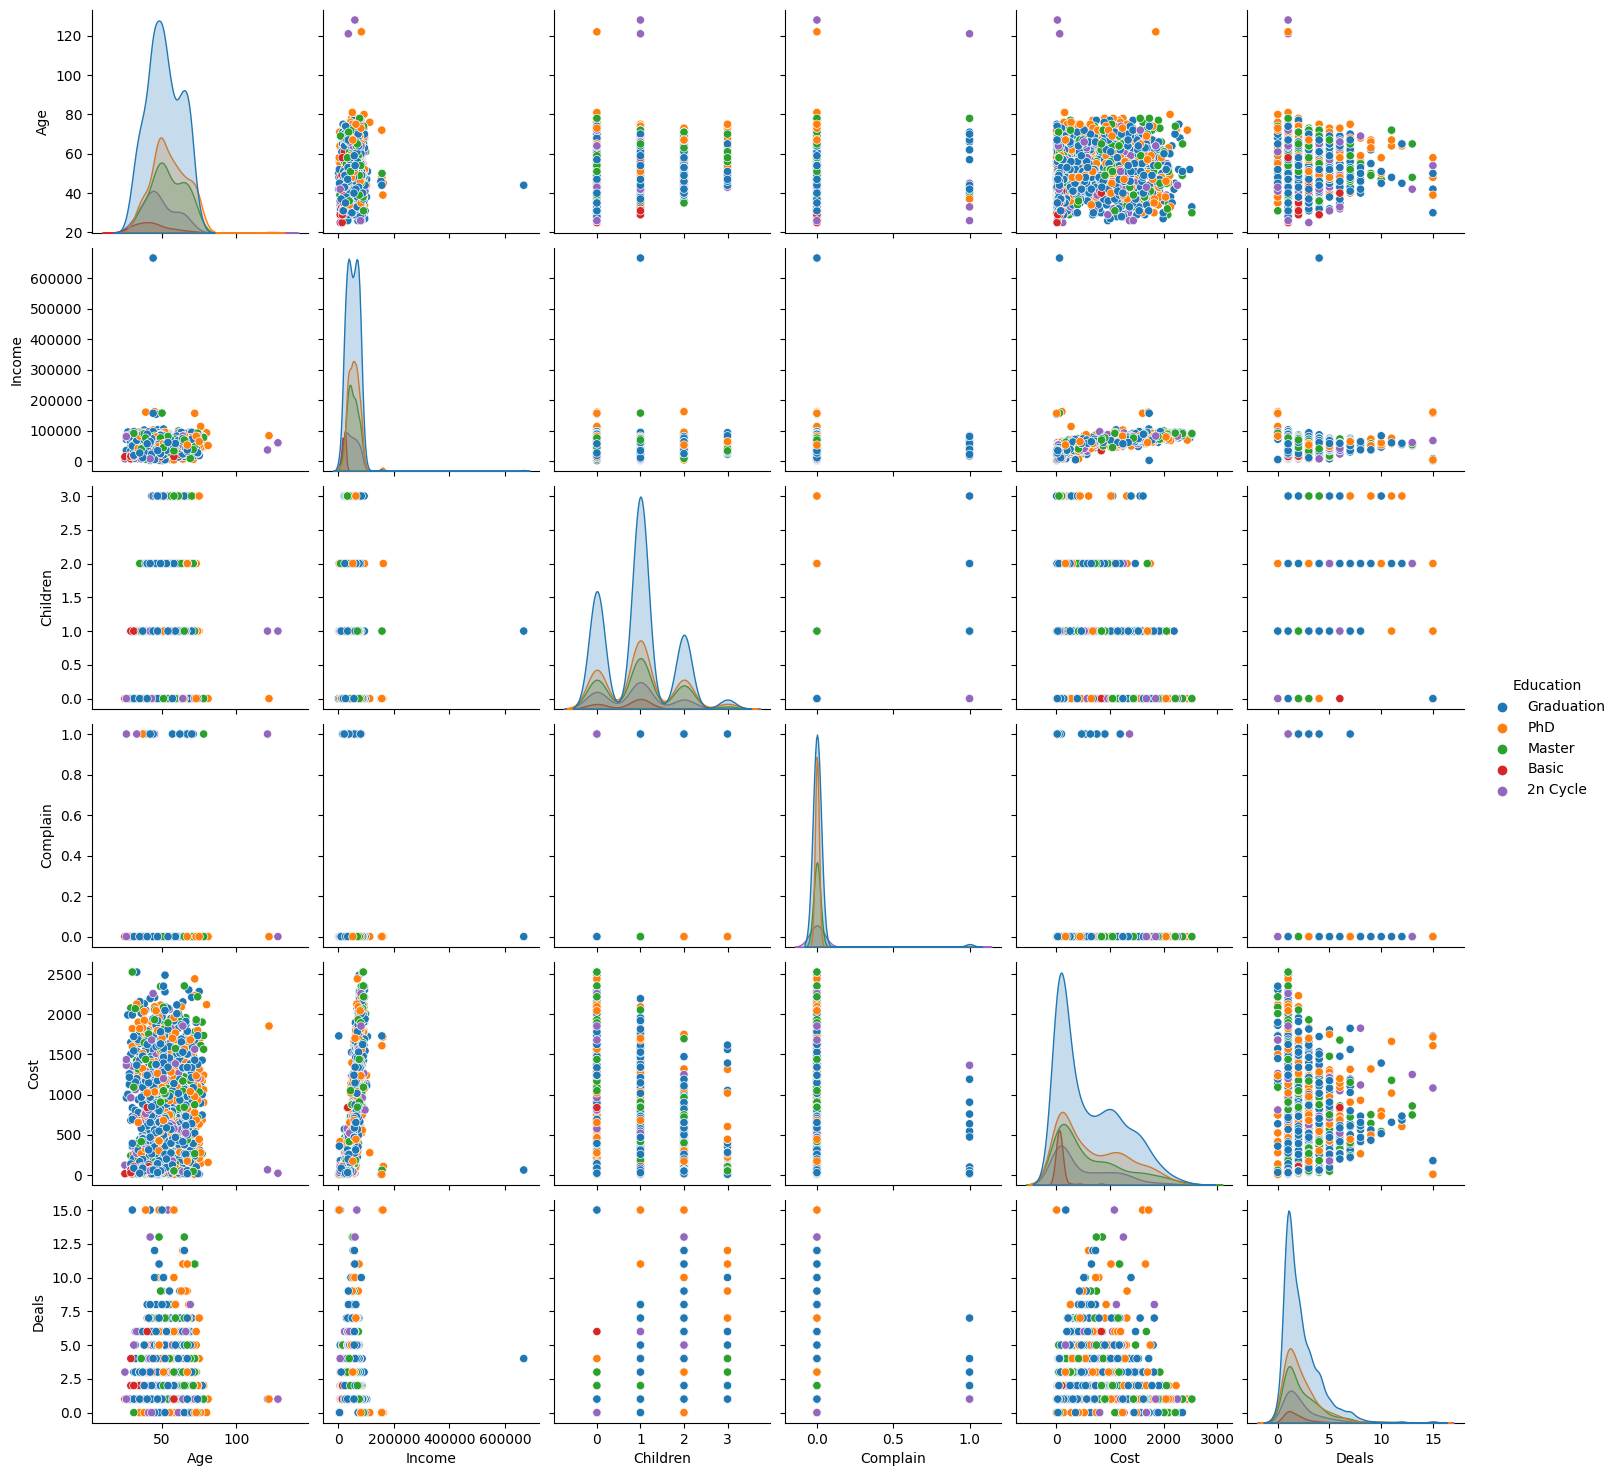

In [8]:
sns.pairplot(data, hue="Education")

## Detect and remove outliers from Age and Income

<Axes: xlabel='Income', ylabel='Count'>

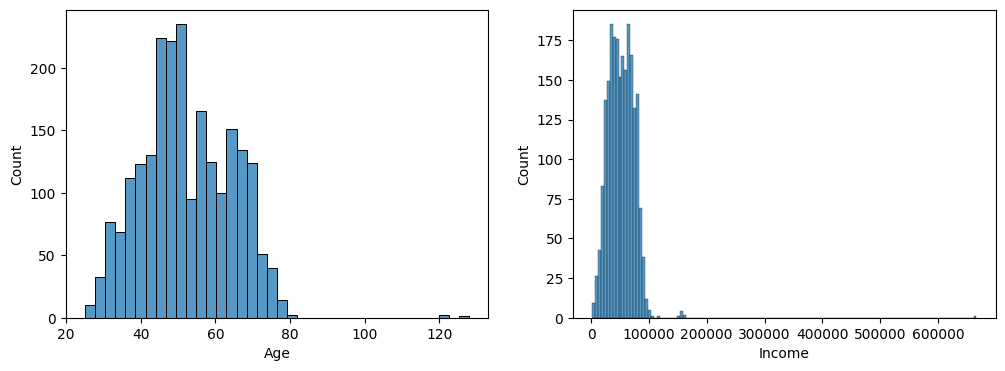

In [11]:
# Deteksi data abnormal / data yang tidak diperlukan

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(data, x='Age', ax=axs[0])
sns.histplot(data, x='Income', ax=axs[1])

In [12]:
trimmed = data[(data.Age < 100) & (data.Income < 130000)] # Mengecualikan data "age" yang lebih dari 100 dan "income" yang lebih dari 130K

# Story Insights
## Income vs Age:
The relationship are mostly mixed except customers with Basic education usually have lower income and expenses.

<Axes: xlabel='Age', ylabel='Cost'>

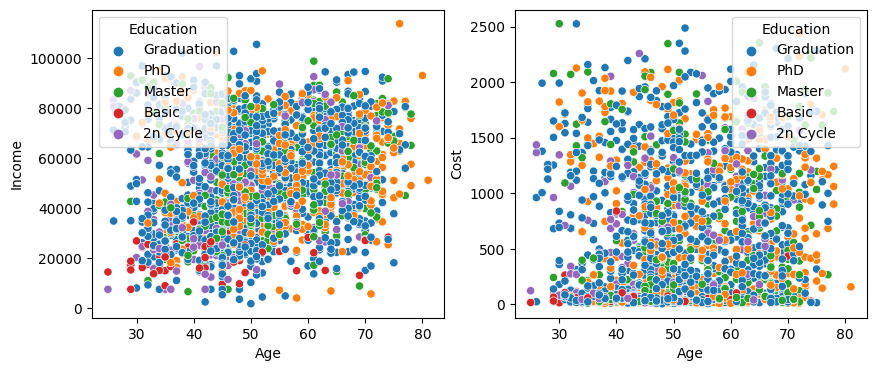

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.scatterplot(trimmed, x='Age', y='Income', hue='Education', ax=axs[0])
sns.scatterplot(trimmed, x='Age', y='Cost', hue='Education', ax=axs[1])

## Story on Feature Correlation

<Axes: >

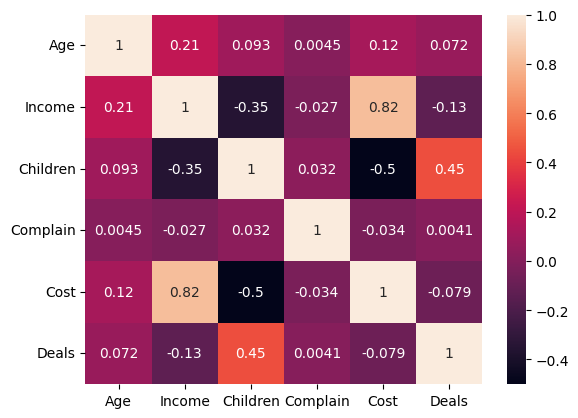

In [15]:
trimmed = trimmed.drop('Education', axis=1)
sns.heatmap(trimmed.corr(), annot=True)

## Deals vs Children - Story Behind High Correlation:
It seems customers who don't have children are concentrated on getting one deal. As the number of children increases, more deals are utilized as well.

<Axes: xlabel='Deals', ylabel='count'>

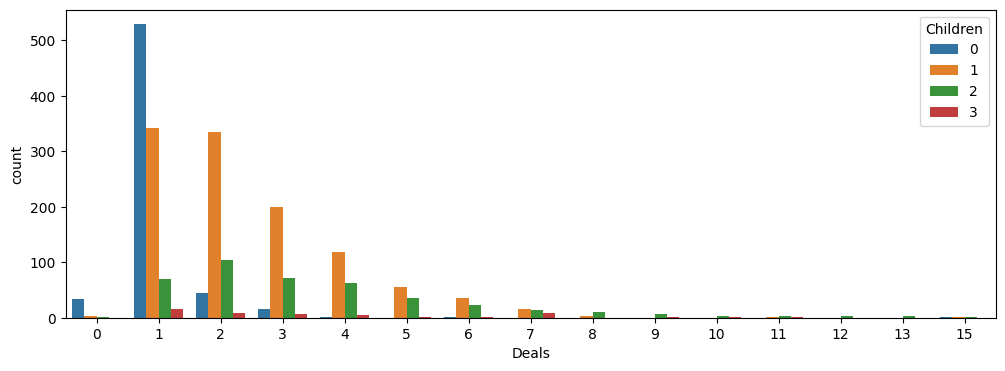

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(trimmed, x='Deals', hue='Children', ax=ax)

## Income vs Cost:
It seems the customers' income and expense are postively correlated.

<Axes: xlabel='Income', ylabel='Cost'>

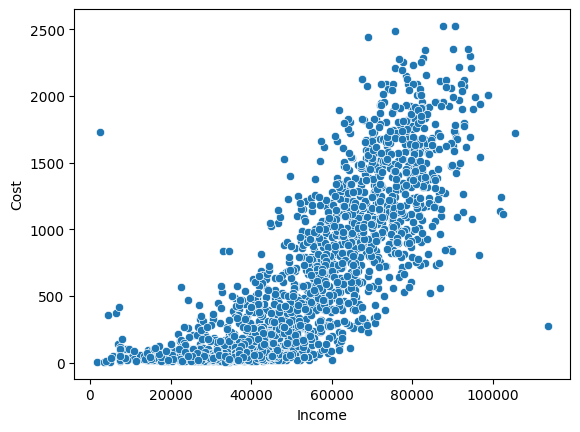

In [17]:
sns.scatterplot(trimmed, x='Income', y='Cost')

# Modeling Time..
## Data prep for modeling
Standardizing features to fit values in the same scale.

In [18]:
scaler = StandardScaler().fit_transform(trimmed)
df = pd.DataFrame(scaler, columns=trimmed.columns)
df.head()

,Age,Income,Children,Complain,Cost,Deals
0,1.017189,0.314651,-1.266589,-0.095673,1.679323,0.361479
1,1.273530,-0.254877,1.403420,-0.095673,-0.963897,-0.168834
2,0.333612,0.965354,-1.266589,-0.095673,0.281242,-0.699147
3,-1.289883,-1.206087,0.068415,-0.095673,-0.920675,-0.168834
4,-1.033542,0.322136,0.068415,-0.095673,-0.307248,1.422105


## 1. KMeans (ME)

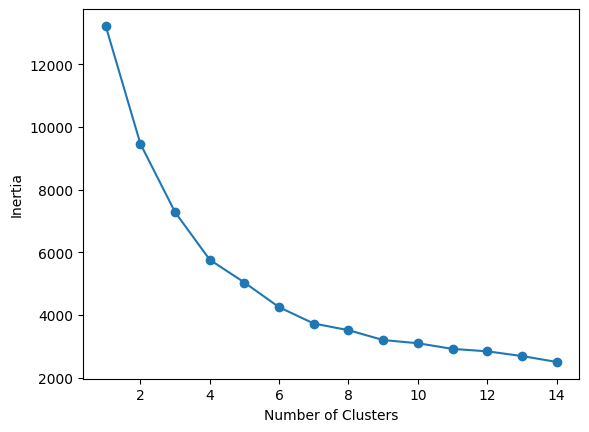

In [19]:
# Find the optimal # of clusters
inertia = []
list_num_clusters = list(range(1,15))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init='k-means++', random_state=666)
    km.fit(df)
    inertia.append(km.inertia_)

plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

<Axes: xlabel='Income', ylabel='Cost'>

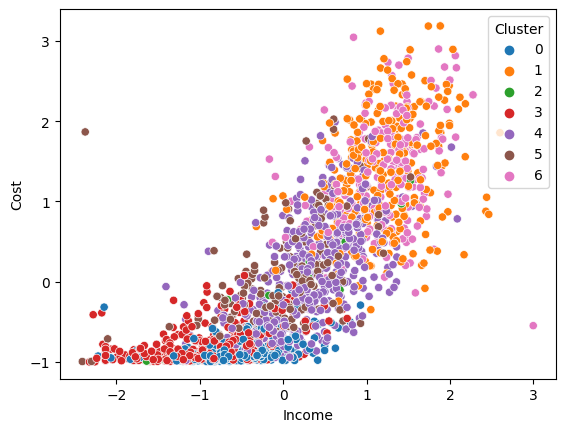

In [20]:
# Decide best K of 7
km = KMeans(n_clusters=7, n_init='auto', init='k-means++', random_state=666)
km.fit(df)
df_km = df.assign(Cluster = km.labels_)

sns.scatterplot(df_km, x='Income', y='Cost', hue='Cluster', palette='tab10')

Silhouette Score for K=7: 0.29934275490226


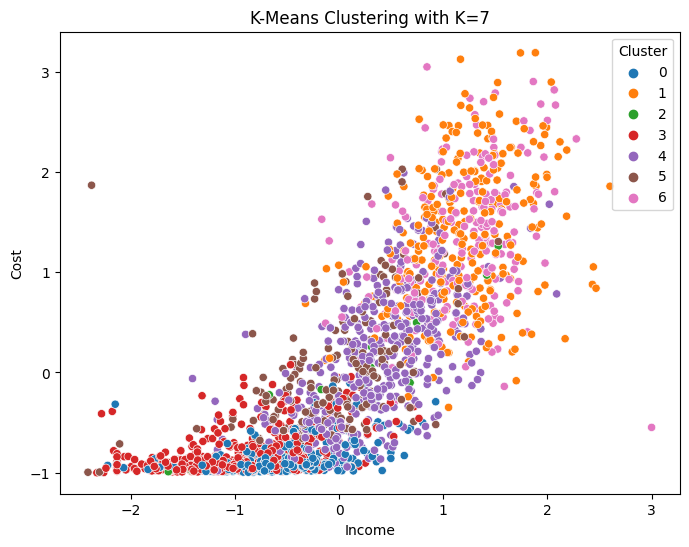

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the data

# Decide best K of 7
km = KMeans(n_clusters=7, n_init='auto', init='k-means++', random_state=666)
km.fit(df)
df_km = df.assign(Cluster = km.labels_)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df, km.labels_)
print(f"Silhouette Score for K=7: {silhouette_avg}")

# Plot the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_km, x='Income', y='Cost', hue='Cluster', palette='tab10')
plt.title('K-Means Clustering with K=7')
plt.show()

## Combine

Silhouette Score for K=7: 0.29934275490226


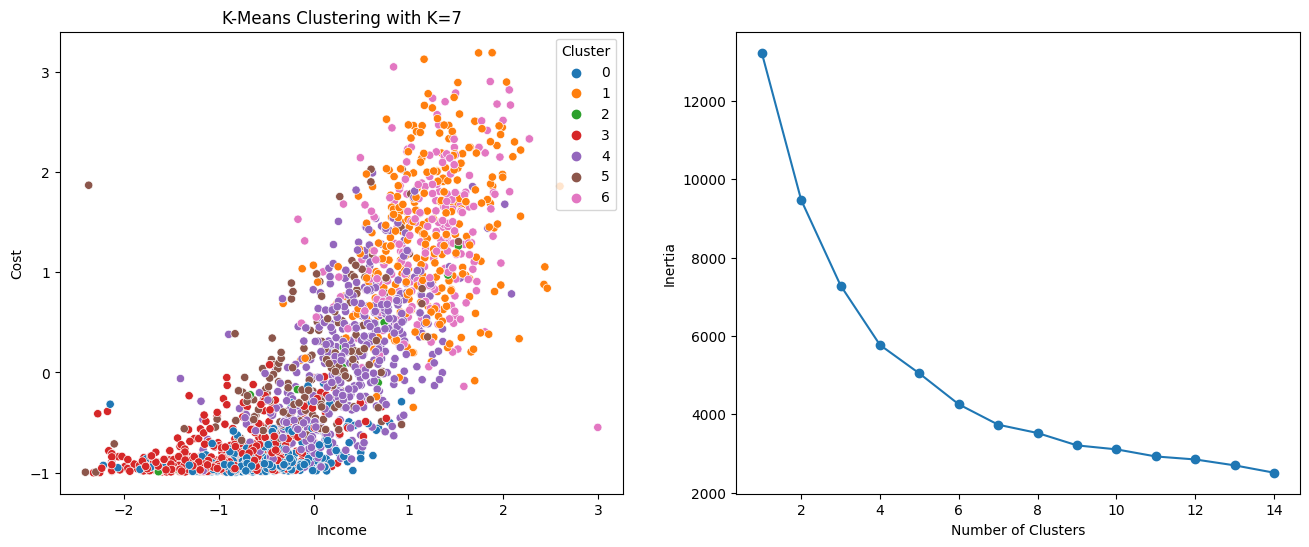

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing the data

# KMeans clustering with k=7
km = KMeans(n_clusters=7, n_init='auto', init='k-means++', random_state=666)
km.fit(df)
df_km = df.assign(Cluster=km.labels_)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df, km.labels_)
print(f"Silhouette Score for K=7: {silhouette_avg}")

# Plot the scatter plot
plt.figure(figsize=(16, 6))

# Subplot 1: Scatter plot
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_km, x='Income', y='Cost', hue='Cluster', palette='tab10')
plt.title('K-Means Clustering with K=7')

# Subplot 2: Elbow Curve
plt.subplot(1, 2, 2)
list_num_clusters = list(range(1, 15))
inertia = []

for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init='k-means++', random_state=666)
    km.fit(df)
    inertia.append(km.inertia_)

plt.plot(list_num_clusters, inertia)
plt.scatter(list_num_clusters, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.show()


In [ ]:
df_km['Cluster'] = df_km['Cluster'].apply(str)
fig = px.scatter_3d(df_km, x='Income', y='Age', z='Cost', color='Cluster',
                    width=800, height=800, title='KMeans Clusters')
fig.update_traces(marker_size = 5)

# Archive

## 2. DBSCAN (ARC)

In [ ]:
# Check # of clusters for diff eps value
import numpy as np
for ep in np.arange(0.1, 1, 0.1):
    dbscan = DBSCAN(eps=ep, min_samples=20).fit(df)
    num_clusters = len(set(dbscan.labels_))
    print(f'When ep = {round(ep, 1)}, there are {num_clusters} clusters.')

When ep = 0.1, there are 1 clusters.
When ep = 0.2, there are 3 clusters.
When ep = 0.3, there are 3 clusters.
When ep = 0.4, there are 5 clusters.
When ep = 0.5, there are 8 clusters.
When ep = 0.6, there are 6 clusters.
When ep = 0.7, there are 6 clusters.
When ep = 0.8, there are 5 clusters.
When ep = 0.9, there are 4 clusters.


<Axes: xlabel='Income', ylabel='Cost'>

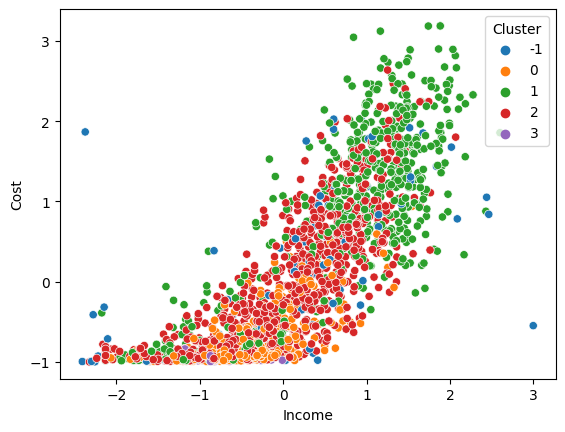

In [ ]:
dbscan = DBSCAN(eps=0.9, min_samples=10).fit(df)
df_dbscan = df.assign(Cluster = dbscan.labels_)
sns.scatterplot(df_dbscan, x='Income', y='Cost', hue='Cluster', palette='tab10')

In [ ]:
df_dbscan['Cluster'] = df_dbscan['Cluster'].apply(str)
fig = px.scatter_3d(df_dbscan, x='Income', y='Age', z='Cost', color='Cluster',
                    width=800, height=800, title='DBSCAN Clusters')
fig.update_traces(marker_size = 5)

## 3. GMM (ARC)

In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='spherical',
                      max_iter=2000, random_state=666).fit(df)
df_gmm = df.assign(Cluster = gmm.predict(df))
df_gmm['Cluster'] = df_gmm['Cluster'].apply(str)

fig = px.scatter_3d(df_gmm, x='Income', y='Age', z='Cost', color='Cluster',
                    width=800, height=800, title='GMM Clusters')
fig.update_traces(marker_size = 5)

# Summary
Recap of some key interesting insights found:
- Most customers income are gathered between \\$30k to \\$90k.
- There are small number of customers who made over \\$600k.
- Customers with `Basic` education usually have lower income and expenses.
- The number deals are influenced by the number of children in the household.
- Customers' income and expense are postively correlated.

Among those 3 models tested, it seems GMM was able to segment the customers the best across Age, Income and Cost. Followed by KMeans, which also has relatively decent separation among the customer segments though it has more clusters. Lastly, DBSCAN could be difficult on finding the best epsilon value.

Some future improvement can be done by including some of those rest unused features, such as the shopping frequency through different channels. In addition, for DBSCAN model, it could be more efficient if kNN can be leveraged to finetune the epsilon parameter.